In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import matplotlib as mpl
sys.path.append('../python/')
os.environ['MPLCONFIGDIR'] = '../mplstyles'


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])

import numpy as np
#set up a plot 
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

# Joint Distributions of Q and $\tilde{E}_r$ to Compare to Edelweiss Paper

The purpose of this notebook is to detail the computation of the joint distribution of Q and $\tilde{E}_r$ (measured ionization yield and measured recoil energy) with and arbitrary effective Fano factor applied. The construction used here is different from the one of Arvind, but it is verified to produce the same results for the probability distribution in ionization yield (called "Q" by Edelweiss) at a given fixed true recoil energy. 

Here is a table of the variables used in computing the distribution. I match Edelweiss variable names where possible.

variable/constant name|Description 
:-|:-
Q|measured ionization yield (CDMS calls this "Y")
$\tilde{E}_r$|measured recoil energy
N|number of e/h pairs
$\delta I$ | instrumental fluctuation on the ionization measurement
$\delta H$ | instrumental fluctuation on the heat measurement
$E_r$ | true recoil energy
$\epsilon$ | average energy to create a single electron-hole pair for an electron-recoil in keV
$V$ |voltage across the detector in Volts
F | effective Fano factor for nuclear-recoils

We seek the joint distribution of Q and $\tilde{E}_r$ given a fixed true energy, $E_r$. It is equal to the 5-variable joint distribution integrated appropriately over the 3 unwanted variables. 

\begin{equation}
P(Q,\tilde{E}_r | E_r) = \int_{-\infty}^{\infty} d(\delta H) \int_{-\infty}^{\infty} d(\delta I) \int_0^{\infty} dN
 P(Q,\tilde{E}_r,\delta H,\delta I, N | E_r)
\end{equation}

The technique used is to write down the 5-variable joint distribution based on the rules of conditional probability and the fact that N, $\delta I$, and $\delta H$ are independent random variables. Then the appropriate integrals can be carried out analytically or numerically. 

## Resolutions

In addition to the variables already defined we need some kind of specifications for the (assumed Gaussian) resolutions on the three fundamental measured variables: N, $\delta I$, and $\delta H$. The resolutions are denoted $\sigma_N$, $\sigma_I$, and $\sigma_H$ respectively, and are assumed to be functions of the true recoil energy $E_r$.

Both the $\sigma_I(E_r)$ and the $\sigma_H(E_r)$ are just the measured resolutions from Edelweiss paper [REF]. 

The $\sigma_N$ is the standard deviation of the number of electron-hole pairs, which can be computed (for a fixed $E_r$) using the effective Fano factor F. It is given simply by:

\begin{equation}
\sigma_N(E_r) = \sqrt{F(\bar{Q}E_r/\epsilon)},
\end{equation}

Where $\bar{Q}$ is the mean ionization yield at $E_r$. Whenever $\bar{Q}$ is written it is tacitly assumed to be a function of the true recoil energy, $E_r$.

We plot the Edw. resolutions just below, for detector GGA110 and GGA3 (the one we will compare to for NR band width). 

In [2]:
#start getting the resolutions
import EdwRes as er

fh1 = er.get_heatRes_func(0.4, 3.5)
heatRes_GGA110 = lambda x: (1/2.355)*fh1(x) #these return FWHM values

fi1 = er.get_ionRes_func(1.1, 1.3, 3.0)
sigI_GGA110 = lambda x:(1/2.355)*fi1(x)

fh2 = er.get_heatRes_func(0.4, 2.7)
heatRes_GGA3 = lambda x:(1/2.355)*fh2(x)

fi2 = er.get_ionRes_func(1.3, 1.5, 3.1)
sigI_GGA3 = lambda x:(1/2.355)*fi2(x)

sigh_GGA110v = np.vectorize(heatRes_GGA110)
sigi_GGA110v = np.vectorize(sigI_GGA110)
sigh_GGA3v = np.vectorize(heatRes_GGA3)
sigi_GGA3v = np.vectorize(sigI_GGA3)

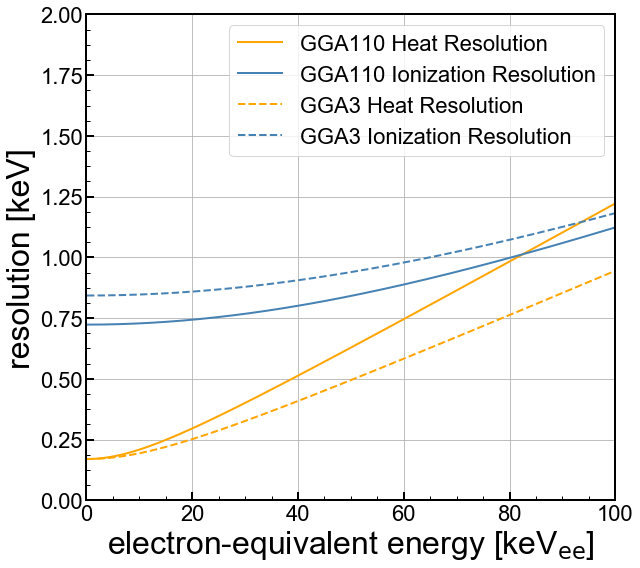

In [3]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

X = np.arange(0.1,100,0.1)

ax1.plot(X,sigh_GGA110v(X),color='orange',linestyle='-',label='GGA110 Heat Resolution')
ax1.plot(X,sigi_GGA110v(X),color='steelblue',linestyle='-',label='GGA110 Ionization Resolution')
ax1.plot(X,sigh_GGA3v(X),color='orange',linestyle='--',label='GGA3 Heat Resolution')
ax1.plot(X,sigi_GGA3v(X),color='steelblue',linestyle='--',label='GGA3 Ionization Resolution')

#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)

ymin = 0
ymax = 2

ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'electron-equivalent energy [keV$_{\mathrm{ee}}$]',**axis_font)
ax1.set_ylabel('resolution [keV]',**axis_font)
ax1.grid(True)
#ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

Note that the summary of the resolutions in the above is relative to the keVee scale, but we want these, instead, to be quoted as a function of the true recoil energy, $E_r$, for a given ionization yield model. We can use the yield model used in the Edelweiss paper:

\begin{equation}
\bar{Q}(E_r) = aE_r^b,
\end{equation}

with a=0.16 and b=0.18. In terms of the average ionization yield, the conversion of the resolution functions to the $E_r$ scale can be accomplished by transforming the $E_r$ energy into the _electron equivalent_ energy for ionization ($E_{\mathrm{ee}}^I$) or heat ($E_{\mathrm{ee}}^h$). 

\begin{equation}
E_{\mathrm{ee}}^h = \frac{\left(1+ \frac{V}{\epsilon}\bar{Q}\right)E_r}{1+\frac{V}{\epsilon}}
\end{equation}

\begin{equation}
E_{\mathrm{ee}}^I = \bar{Q}E_r
\end{equation}

Note that these two definitions are equivalent when the average ionization yield is one (like for electron-recoils), but differs when the average ionization yield is not one. This underscores the fact that heat and ionization scales cannot be universally (for all recoil types) defined because the average ionization yield does not affect "primary" phonon production and Luke phonon production in the same way. 

In [4]:
#yield model
a=0.16
b=0.18
Qbar = lambda Er: a*Er**b

#constants
V=4.0 #volts
eps = 3.0/1000 #keV per pair, I usually use 3.3 for the numerator, but Edw. uses 3.

#new resolution functions 
Ehee = lambda Er: ((1+(V/eps)*Qbar(Er))*Er)/(1+(V/eps))
EIee = lambda Er: Qbar(Er)*Er

heatRes_GGA110_Er = lambda Er: heatRes_GGA110(Ehee(Er))

sigI_GGA110_Er = lambda Er: sigI_GGA110(EIee(Er))

heatRes_GGA3_Er = lambda Er: heatRes_GGA3(Ehee(Er))

sigI_GGA3_Er = lambda Er: sigI_GGA3(EIee(Er))

sigh_GGA110_Erv = np.vectorize(heatRes_GGA110_Er)
sigi_GGA110_Erv = np.vectorize(sigI_GGA110_Er)
sigh_GGA3_Erv = np.vectorize(heatRes_GGA3_Er)
sigi_GGA3_Erv = np.vectorize(sigI_GGA3_Er)

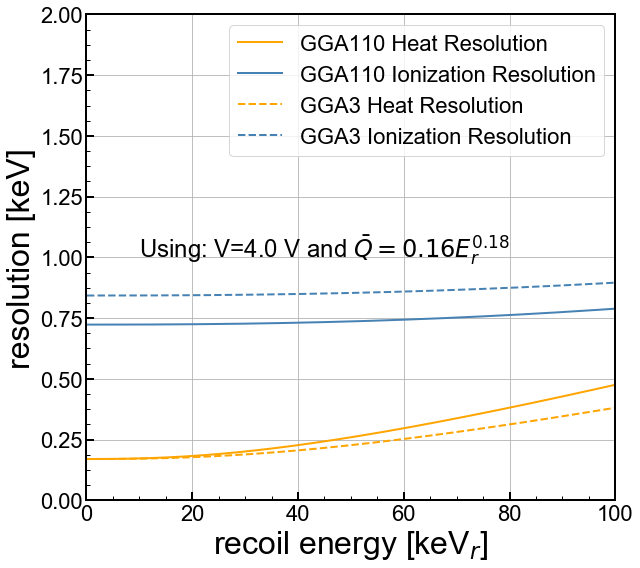

In [5]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

X = np.arange(0.1,100,0.1)

ax1.plot(X,sigh_GGA110_Erv(X),color='orange',linestyle='-',label='GGA110 Heat Resolution')
ax1.plot(X,sigi_GGA110_Erv(X),color='steelblue',linestyle='-',label='GGA110 Ionization Resolution')
ax1.plot(X,sigh_GGA3_Erv(X),color='orange',linestyle='--',label='GGA3 Heat Resolution')
ax1.plot(X,sigi_GGA3_Erv(X),color='steelblue',linestyle='--',label='GGA3 Ionization Resolution')

#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)
ax1.text(10,1.0,"Using: V=4.0 V and $\\bar{Q}=0.16E_r^{0.18}$",fontsize=24)

ymin = 0
ymax = 2

ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV$_{r}$]',**axis_font)
ax1.set_ylabel('resolution [keV]',**axis_font)
ax1.grid(True)
#ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

## The Conditional Distribution

Since the resolutions are now known as functions of the true recoil energy, we turn to the construction of the conditional probability $P(Q,\tilde{E}_r,\delta H, \delta I,N|E_r)$. We base this on the fact that the variables Q, $\tilde{E}_r$ are _completely derived_ variables and that the random variables N, $\delta I$, and $\delta H$ are _totally independent_. 

Q and $\tilde{E}_r$ are constructed from N, $\delta I$, $\delta H$, and $E_r$ by the following equations:

\begin{equation}
\tilde{E}_r = E_r + \left(1 + \frac{V}{\epsilon}\right)\delta H - \left(\frac{V}{\epsilon}\right) \delta I,
\end{equation}

\begin{equation}
Q = \frac{\epsilon N + \delta I}{E_r + \left(1 + \frac{V}{\epsilon} \right) \delta H - \left(\frac{V}{\epsilon}\right) \delta I}.
\end{equation}

With these equations we can simply write down the highly-conditional joint distribution since the variables Q and $\tilde{E}_r$ contain no information except that which is contained in the other variables. 

\begin{equation}
P(Q,\tilde{E}_r | \delta H, \delta I, N, E_r) = \delta_r\left(\tilde{E}_r - \left[E_r + \left(1+\frac{V}{\epsilon}\right)\delta H -\left(\frac{V}{\epsilon}\right)\delta I\right] \right) \delta_Q \left(Q - \left[\frac{\epsilon N + \delta I}{E_r + \left(1+V/\epsilon\right)\delta H - (V/\epsilon) \delta I}\right]\right),
\end{equation}

where $\delta_r$ and $\delta_Q$ represent Dirac delta function distributions of the listed variables. 

After that we can just construct the needed conditional probability by multiplying by the probability distributions of the independent random variables N, $\delta H$, and $\delta I$. 

\begin{equation}
P(Q,\tilde{E}_r,\delta H, \delta I, N|E_r) = P(Q,\tilde{E}_r|\delta H,\delta I, N, E_r)P(\delta H)P(\delta I)P(N)
\end{equation}

## The 5-Variable Joint Distribution

The 5-variable joint distribution can now simply be written down, because the probability distributions of all of the independent random variables are just Gaussian. 

\begin{equation}
P(Q,\tilde{E}_r,\delta H, \delta I, N|E_r) = N_{IHN} \delta_Q \delta_r exp\left[-\frac{\delta I^2}{2\sigma_I^2}\right]exp\left[-\frac{\delta H^2}{2\sigma_H^2}\right]exp\left[-\frac{\left(\bar{N} - N\right)^2}{2\sigma_N^2}\right],
\end{equation}

where $\bar{N}$ is the mean number of electron-hole pairs and is equal to $\bar{Q}E_r/\epsilon$, and $N_{IHN}$ is a conglomeration of all the factors that do not depend on the independent random variables, as below:

\begin{equation}
N_{IHN} = \frac{1}{\sqrt{2\pi\sigma_I^2}}\frac{1}{\sqrt{2\pi\sigma_H^2}}\frac{1}{\sqrt{2\pi\sigma_N^2}},
\end{equation}

Note that this _is_ a function of the true recoil energy, $E_r$. Now to get the analytical representation of the function we want, $P(Q,\tilde{E}_r|E_r)$, we need to integrate over $\delta H$, N, and $\delta I$ as described above. 

### Integrating Over $\delta H$

Because of the Dirac delta function $\delta_r$, this integral is fairly trivial. Since in the delta function we have the factor $\left(1+ (V/\epsilon)\right)$ preceding the $\delta H$ we need to do a change-of-variable to use the delta function in the most straight-forward way. Let's do:

\begin{equation}
\begin{aligned}
\chi_0 &\equiv \left(1+(V/\epsilon)\right) \delta H \\
d\chi_0 &= \left(1+(V/\epsilon)\right) d(\delta H).
\end{aligned}
\end{equation}

This will modify the distribution by a constant factor in addition to eliminating $\delta H$. The result is:

\begin{equation}
P(Q,\tilde{E}_r, \delta I, N|E_r) = \frac{N_{IHN}}{1+\left(\frac{V}{\epsilon}\right)} \delta_Q exp\left[-\frac{\delta I^2}{2\sigma_I^2}\right]exp\left[-\frac{\left(\tilde{E}_r - E_r + (V/\epsilon) \delta I\right)^2}{2\left[\left(1+(V/\epsilon)\right)\sigma_H\right]^2}\right]exp\left[-\frac{\left(\bar{N} - N\right)^2}{2\sigma_N^2}\right].
\end{equation}

### Integrating Over N

By integrating over $\delta H$ and inserting its post-integration value into the $\delta_Q$ function, we have a new form for that delta function:

\begin{equation}
\delta_Q = \delta\left(Q - \left[\frac{\epsilon N + \delta I}{\tilde{E}_r}\right]\right)
\end{equation}

We now want to execute the integration over the independent variable N. N does not appear as a simple additive term in the argument of the delta function, so we have to do another change-of-variables. 

\begin{equation}
\begin{aligned}
\chi_1 &= \frac{\epsilon N}{\tilde{E}_r} \\
d\chi_1 &=\frac{\epsilon}{\tilde{E}_r} dN
\end{aligned}
\end{equation}

This change of variables in the integral of N (which ranges from 0 to $\infty$) is a little tricky, basically because $\tilde{E}_r$ can be negative. Strictly speaking, the result should be written as a piecewise function for the cases of $\tilde{E}_r < 0$ or $\tilde{E}_r \geq 0$. 

However, in the first case the limits of the $\chi_1$ integral are 0 to $-\infty$, wheras in the second case the limits are 0 to $\infty$. Furthermore the _results_ of the integrals are simply the negatives of each other. That means we can obtain the same result in a single formula, if we simply replace the $\tilde{E}_r$ in the Jacobian with $|\tilde{E}_r|$.

The result is:

\begin{equation}
P(Q,\tilde{E}_r, \delta I|E_r) = \frac{N_{IHN}}{1+\left(\frac{V}{\epsilon}\right)}\frac{|\tilde{E}_r|}{\epsilon} exp\left[-\frac{\delta I^2}{2\sigma_I^2}\right]exp\left[-\frac{\left(\tilde{E}_r - E_r + (V/\epsilon) \delta I\right)^2}{2\left[\left(1+(V/\epsilon)\right)\sigma_H\right]^2}\right]exp\left[-\frac{\left(E_r\bar{Q} - \tilde{E}_rQ-\delta I\right)^2}{2\epsilon^2\sigma_N^2}\right].
\end{equation}

### Integrating Over $\delta I$

The final integral is not assisted by the presence of any delta functions. We can organize the exponential terms by the powers of the $\delta I$ in the exponents, as thus:

\begin{equation}
P(Q,\tilde{E}_r, \delta I|E_r) = \left\{\frac{N_{IHN}}{1+\left(\frac{V}{\epsilon}\right)}\frac{|\tilde{E}_r|}{\epsilon}
exp\left[-\frac{\left(\tilde{E}_r - E_r\right)^2}{2\left[\left(1+(V/\epsilon)\right)\sigma_H\right]^2}\right]
exp\left[-\frac{\left(E_r\bar{Q} - \tilde{E}_rQ\right)^2}{2\epsilon^2\sigma_N^2}\right] \right\} \times
\left\{exp\left[-\frac{2\frac{V}{\epsilon}\left(\tilde{E}_r - E_r\right)\delta I}{2\left[\left(1+(V/\epsilon)\right)\sigma_H\right]^2}\right]
exp\left[-\frac{2\left(E_r\bar{Q} - \tilde{E}_rQ\right)\delta I}{2\epsilon^2\sigma_N^2}\right] \right\} \times
\left\{exp\left[-\frac{\delta I^2}{2\sigma_I^2}\right]
exp\left[-\frac{\left((V/\epsilon) \delta I\right)^2}{2\left[\left(1+(V/\epsilon)\right)\sigma_H\right]^2}\right]
exp\left[-\frac{\delta I^2}{2\epsilon^2\sigma_N^2}\right] \right\}.
\end{equation}

The integral of this over $\delta I$ from $-\infty$ to $\infty$ is therefore of the form:

\begin{equation}
C\int_{-\infty}^{\infty} e^{-ax}e^{-bx^2} dx = \frac{Ce^{\frac{a^2}{4b}}\sqrt{\pi}}{\sqrt{b}}
\end{equation}


## Joint Distribution in Q, $\tilde{E}_r$ for a Fixed $E_r$

We can make the following definitions to use the results above. 

\begin{equation}
\begin{aligned}
C(\tilde{E}_r,Q,E_r) &= \frac{N_{IHN}}{1+\left(\frac{V}{\epsilon}\right)}\frac{|\tilde{E}_r|}{\epsilon}
exp\left[-\frac{\left(\tilde{E}_r - E_r\right)^2}{2\left[\left(1+(V/\epsilon)\right)\sigma_H\right]^2}\right]
exp\left[-\frac{\left(E_r\bar{Q} - \tilde{E}_rQ\right)^2}{2\epsilon^2\sigma_N^2}\right] \\
a(\tilde{E}_r,Q,E_r) &= \left[\frac{2\frac{V}{\epsilon}\left(\tilde{E}_r - E_r\right)}{2\left[\left(1+(V/\epsilon)\right)\sigma_H\right]^2}
+\frac{2\left(E_r\bar{Q} - \tilde{E}_rQ\right)}{2\epsilon^2\sigma_N^2}\right] \\
b(\tilde{E}_r,Q,E_r) &= \left[\frac{1}{2\sigma_I^2} +\frac{\left((V/\epsilon)\right)^2}{2\left[\left(1+(V/\epsilon)\right)\sigma_H\right]^2} + \frac{1}{2\epsilon^2\sigma_N^2}\right]
\end{aligned}
\end{equation}

So, the final distribution is, in terms of these definitions:

\begin{equation}
P(Q,\tilde{E}_r,|E_r) = \frac{C(\tilde{E}_r,Q,E_r)exp\left[ \frac{a(\tilde{E}_r,Q,E_r)^2}{4b(\tilde{E}_r,Q,E_r)}\right] \sqrt{\pi}}{\sqrt{b(\tilde{E}_r,Q,E_r)}}
\end{equation}

This function has been coded into the file `../prob_dist.py` under the function name `QEr_v2_2D_fast`. The way it works is that you supply all the necessary inputs (functions or variables) to that function and it returns a function object. 

In [6]:
#Jardin resolutions
import resfuncRead as rfr

#read the files
ptres = rfr.getRFunc('../data/jardin_ptres.txt')
qres = rfr.getRFunc('../data/jardin_qsummaxres.txt')

#make the resolution functions
sigp = rfr.makeRFunc(ptres[1]['sqrt'])
sigq = rfr.makeRFunc(qres[1]['lin'],True)

In [7]:
import prob_dist as pd

F=10
Etest=10
P = pd.QEr_v2_2D_fast(heatRes_GGA3_Er,sigI_GGA3_Er,V,eps,F,Qbar)
P1 = pd.YEr_v2_2D_fast(sigp,sigq,V,eps,F,Qbar)
P2 = pd.YEr_v2_2D(sigp,sigq,V,eps,F,Qbar)



#print(P(0.2,10,10))

#check for normalization
from scipy import integrate
#norm = integrate.dblquad(P1, 0, 10, 0, 200,args=(40,))
#print(norm)

#only integrate over important part of distribution around Etr
#I empirically found in analysis/misc/nrFano_Constraint/extract_Edw_Fano_v2.ipynb
#that at Etr=10keV the width should be 3 keV and at 40 keV it should be 10 keV

m = (10-3.0)/(40-10)
icpt = 3-m*10
width = lambda Etr: m*Etr + icpt



lowlim=Etest-3*width(Etest)
uplim=Etest+3*width(Etest)
Pq = lambda Q: integrate.quad(lambda Etr,Q,Er:P(Q,Etr,Er),lowlim,uplim,args=(Q,Etest,))[0]
P1q = lambda Q: integrate.quad(lambda Etr,Q,Er:P1(Q,Etr,Er),lowlim,uplim,args=(Q,Etest,))[0]
print(Pq(0.2))
norm = integrate.quad(Pq,-0.2,4)
print(norm)
norm = integrate.quad(P1q,-0.2,4)
print(norm)

3.502385308789395
(0.9999999998482907, 8.162112702218239e-10)
(1.0000000000176736, 1.4413085435219242e-08)


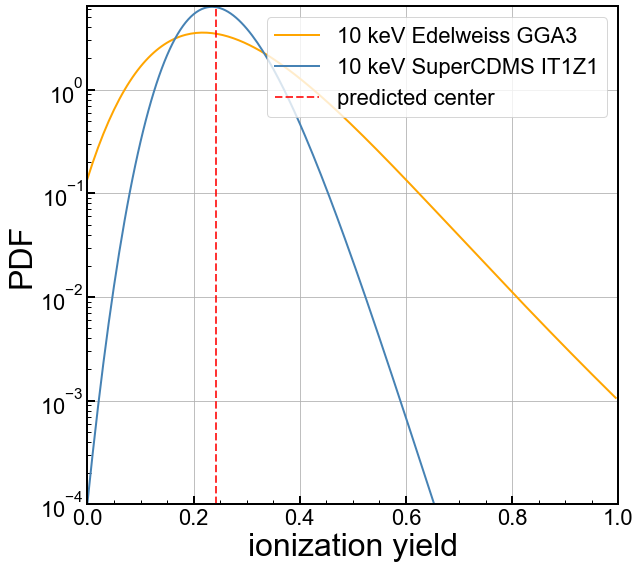

In [8]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

Pqv = np.vectorize(Pq)
P1qv = np.vectorize(P1q)

X = np.arange(0,1,0.005)
Y = Pqv(X)
Y1 = P1qv(X)


ax1.plot(X,Y,color='orange',linestyle='-',label='{} keV Edelweiss GGA3'.format(Etest))
ax1.plot(X,Y1,color='steelblue',linestyle='-',label='{} keV SuperCDMS IT1Z1'.format(Etest))

ax1.axvline(Qbar(Etest), color='r', linestyle='--', lw=2, alpha=0.8,label='predicted center')

ymin = 1e-4
max1 = np.max(Y)
max2 = np.max(Y1)
ymax = 1.01*np.max(np.asarray([max1,max2]))

ax1.set_yscale('linear')
ax1.set_yscale('log')
ax1.set_xlim(0, 1) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'ionization yield',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
#ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

In [9]:
#let's try to get a look at a contour plot
PQEr = lambda Q,Etr:P(Q,Etr,Etest)
xnr = np.linspace(Etest-3*width(Etest), Etest+3*width(Etest), 300)
ynr = np.linspace(0.0, 0.7, 300)

Xnr, Ynr = np.meshgrid(xnr, ynr)
PQEr_v = np.vectorize(PQEr)
Znr = PQEr_v(Ynr,Xnr)

[ 1.    1.01  1.02 ... 18.97 18.98 18.99]


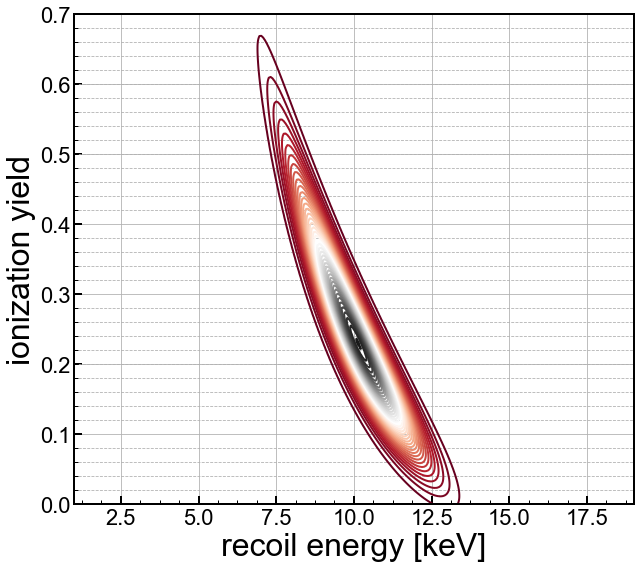

In [10]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

#make a model for the line I think the max probability should lie on
Xhy = np.arange(Etest-3*width(Etest),Etest+3*width(Etest),0.01)
print(Xhy)
fhy = lambda x: Qbar(Etest)*Etest/x
#well, this doesn't seem to predict the curve matching the max in the 2D distribution, but this is
#the naive estimate not accounting for correlations, the question is:
#along which line in the Y,Etr space should the distribution be for a given true recoil energy Etest

#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
#ax1.plot(x, ingrndv_alt(x),label='E$_r$ function')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
ax1.contour(Xnr, Ynr, Znr, 50,cmap='RdGy');
#ax1.plot(Xhy,fhy(Xhy),label='Max proability',color='goldenrod',linestyle='--')


ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(Etest-3*width(Etest), Etest+3*width(Etest)) 
ax1.set_ylim(0.0,0.7)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=2,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()

## Adding in the True $E_r$ Distribution

Everything in the preceeding sections made calculations for a fixed true $E_r$. When measurements are executed in a real world device, even the true energy is in some sense a random variable, with a probability distribution dependent on the probability of a neutron (say) to impart a specific recoil energy to a nuclei that it scatters off of. 

Since this random variable is clearly independent of all the random variables studied so far (those have to do with detector fluctuations and electronic and/or analysis noise) we can construct the joint distribution $P(Q,\tilde{E}_r,E_r)$ at once:

\begin{equation}
P(Q,\tilde{E}_r,E_r) = P(Q,\tilde{E}_r|E_r)P(E_r),
\end{equation}

Where $P(E_r)$ is the probability density function of the true recoils. 

A plausible model for $P(E_r)$ is a pure exponential with a decay constant around 1/100 keV$^{-1}$. This can model in a rough sense broadband neutron sources like $^{252}$Cf. In that case the probability distribution of the true $E_r$ values is:

\begin{equation}
P(E_r) = \frac{1}{\alpha}e^{-\alpha E_r},
\end{equation}

where $\alpha$ is the decay constant and we take to be equal to about 1/100 keV$^{-1}$. Using this model we can immediately find the two-dimensional experimental Q,$\tilde{E}_r$ distribution for such a nuclear recoil source, it is:

\begin{equation}
P(Q,\tilde{E}_r) = \int_0^{\infty} dE_r P(Q,\tilde{E}_r|E_r)P(E_r).
\end{equation}

With the functions constructed in the previous section we have all the ingredients to compute this distribution. Simply take the two-dimensional function returned from `QEr_v2_2D_fast` in the library `../prob_dist.py` and that is a three-argument function which is equal to $P(Q,\tilde{E}_r|E_r)$ with arguments in the order Q,$\tilde{E}_r$,$E_r$. Using that and our above definition of $P(E_r)$ we can get the desired distribution. 

**NOTE: The function $P(Q,\tilde{E}_r|E_r)$ is difficult to numerically integrate over all $E_r$ for a fixed $\tilde{E}_r$ I think because it is sharply peaked near $E_r$=$\tilde{E}_r$. Therefore, as above, I typically empirically find limits for the $E_r$ based on the value of $\tilde{E}_r$ which approximate the integral quite well but doesn't turn the integrand into a function that is defined one a wide range but only non-zero on a set of very small measure compared to the domain.** 

There is another function in the library `../prob_dist.py`, `expband_2D` that can return the two-dimensional function given the three-dimensional proability distribution $P(Q,\tilde{E}_r,E_R)$, and $\alpha$ as defined above. 

In [11]:
#Get two-dimensional band function
nr_band = pd.expband_2D(P,(1/100))

xnr = np.linspace(1, 100, 200)
ynr = np.linspace(0.0, 0.7, 200)

Xnr, Ynr = np.meshgrid(xnr, ynr)
nr_band_v = np.vectorize(nr_band)
Znr = nr_band_v(Ynr,Xnr)

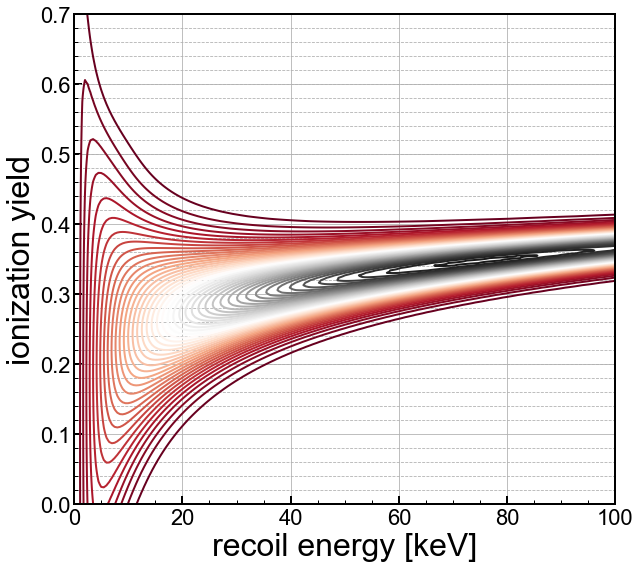

In [12]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
#ax1.plot(x, ingrndv_alt(x),label='E$_r$ function')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
ax1.contour(Xnr, Ynr, Znr, 50,cmap='RdGy');
#ax1.plot(Xhy,fhy(Xhy),label='Max proability',color='goldenrod',linestyle='--')


ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(0.0,0.7)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=2,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()